# Caracterização da Amostra

O nosso Dataset descreve dois conjuntos de dados com elementos que caraterizam reservas em  hotéis e resorts
como sejam, hotéis (H1) é um hotel resort e o outro é um hotel urbano (H2). 

Um dos hotéis (H1) é um hotel resort e o outro é um hotel da cidade (H2). Ambos os conjuntos de dados compartilham a mesma estrutura, com 31 variáveis descrevendo as 40.060 observações de H1 e 79.330 observações de H2. Cada observação representa uma reserva de hotel. Ambos os conjuntos de dados compreendem reservas previstas para chegar entre 1º de julho de 2015 e 31 de agosto de 2017, incluindo reservas que efetivamente chegaram e reservas que foram canceladas. Como se trata de dados reais do hotel, todos os elementos de dados relativos à identificação de hotel ou cliente foram excluídos.


# Imports

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import normaltest
import networkx as nx
import igraph as ig
import warnings

warnings.filterwarnings('ignore')
significance = 0.05

# Helpers Methods - Candidate to be a py file

In [135]:
def get_frequences_by_column(dataframe, column, sturger_class):
    frequence = pd.value_counts(
        pd.cut(
            x = dataframe[column],
            bins = sturger_class,
            include_lowest = True
        ),
        sort = False
    )
    return frequence

def get_percentage_by_column(dataframe, column, sturger_class):
    percentage = pd.value_counts(
        pd.cut(
            x = dataframe[column],
            bins = sturger_class,
            include_lowest = True
        ),
        sort = False,
        normalize = True
    )
    return percentage

def print_media_median_mode(dataframe, column):
    print(f'Mean is {dataframe[column].mean()} \nMedian is {dataframe[column].median()}\nMode is {dataframe[column].mode()[0]}')


def jaccard_generalized(groups):
    '''
        E se a divisão for zero
    '''
    lines = groups.shape[0]
    similarity_matrix = np.empty((lines, lines))
    count = 0
    for _ in groups.tolist():
        aux = 0
        for __ in groups.tolist():
            numerator = float(np.sum(np.minimum(groups[count, :], groups[aux, :])))
            denominator = float(np.sum(np.maximum(groups[count, :], groups[aux, :])))
            if denominator != 0:
                similarity_matrix[count, aux] = numerator/denominator
            aux = aux + 1
        count = count + 1
    
    return similarity_matrix

def prox2dist(P, k):
    distance = np.power(1.0/P-1.0, k)
    return distance

def matrix2graph(adj):
    g = ig.Graph.Weighted_Adjacency(np.ndarray.tolist(adj))
    return g

def all_pairs_sp(D):
    g = matrix2graph(D)
    DC = g.shortest_paths_dijkstra(weights=g.es['weight'], mode='OUT')
    DC = np.asarray(DC)
    return DC

def s_ratio(D,DC):
    s = np.divide(D,DC)
    return s

def Semimetric_Percentage(s):
    s_infs = ~(np.isinf(s))
    sm_edges = s > 1
    m_edges = s <= 1
    s_positive = s > 0

    s_infs.astype(int)
    sm_edges.astype(int)
    m_edges.astype(int)
    s_positive.astype(int)

    sm_edges = np.multiply(s_infs, sm_edges)
    m_edges = np.multiply(s_positive, m_edges)

    t_sm_edges = sm_edges.sum()
    t_m_edges = m_edges.sum()

    smp = float(t_sm_edges) / (float(t_m_edges) + float(t_sm_edges))
    return smp

def Metric_backbone(P):
    D = prox2dist(P,1)

    DC = all_pairs_sp(D)
    s=s_ratio(D,DC)

    s_infs = ~(np.isinf(s))
    sm_edges = s > 1
    m_edges = s <= 1
    s_positive = s>0

    s_infs.astype(int)
    sm_edges.astype(int)
    m_edges.astype(int)
    s_positive.astype(int)

    sm_edges = np.multiply(s_infs, sm_edges)
    m_edges = np.multiply(s_positive, m_edges)

    MB = np.multiply(P, m_edges)

    return MB

# Reading

In [136]:
dataframe = pd.read_csv ('hotel_bookings.csv')

# Descrição das Variáveis 

- Das 32 variáveis que constituem o nosso dataset, verificamos que apenas 2 são categóricas do tipo booleano (Verdadeiro ou Falso): "is canceled " e "is_repeated_guest".

In [137]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

**hotel**                           Hotel (H1 = Resort Hotel or H2 = City Hotel)  
**is canceled**                     Value indicating if the booking was canceled (1) or not (0)  
**lead_time**                       days between the entering date of the booking into the PMS and the arrival date  
**arrival_date_year**               Year of arrival date  
**arrival_date_month**              Month of arrival date  
**arrival_date_week_number**        Week number of year for arrival date  
**arrival_date_day_of_month**       Day of arrival date  
**stays_in_weekend_nights**         Number of weekend nights(Sat or Sun)the guest stayed or booked to stay at the hotel  
**stays_in_week_nights**            Number of week nights (Mon to Fri) the guest stayed or booked to stay at the hotel  
**adults**                          Number of adults  
**children**                        Number of children  
**babies**                          Number of babies  
**meal**                            Type of meal booked. Standard hospitality meal packages: Undefined/SC – no meal  
**country**                         Categories are represented in the ISO 3155–3:2013 format  
**market_segment**                  Market segment designation. “TA” - “Travel Agents” and “TO” - “Tour Operators”  
**distribution_channel**            Booking distribution. The term “TA” - “Travel Agents” and “TO” - “Tour Operators”  
**is_repeated_guest**               Value indicating if the booking name was from a repeated guest (1) or not (0)  
**previous_cancellations**          Number of previous bookings that were cancelled by the customer  
**previous_bookings_not_canceled**  Number of previous bookings not cancelled by the customer  
**reserved_room_type**              Code of room type reserved  
**assigned_room_type**              Code for the type of room assigned to the booking  
**booking_changes**                 Changes made to the booking from the moment the booking was entered   
**deposit_type**                    Indication on if the customer made a deposit to guarantee the booking  
**agent**                           ID of the travel agency that made the booking  
**company**                         ID of the company/entity that made the booking  
**days_in_waiting_list**            Number of days the booking was in the waiting list  
**customer_type**                   Type of booking, assuming one of four categories  
**adr**                             Average Daily Rate as defined by dividing the sum of all lodging transactions  
**required_car_parking_spaces**     Number of car parking spaces required by the customer    
**total_of_special_requests**       Number of special requests made by the customer (e.g. twin bed or high floor)  
**reservation_status**              Reservation last status, assuming one of three categories  
**reservation_status_date**         Date at which the last status was set  

# Objetivo da Investigação e Perguntas Exploratórias

- Este conjunto de dados contém informações de reserva para um hotel da cidade e um hotel de resort, e inclui informações como quando a reserva foi feita, e que nos irá permitir caracterizar os cancelamentos da reserva.

- As variáveis analisadas serão:
    - hotel
    - is_repeatable_guest

- Neste sentido, temos como hipótese que estas duas variáveis influenciam no cancelamento ou não de uma reserva


# Exploring

- Foi feita uma visualização por país: Portugal(PRT) e Espanha(ESP)

In [36]:

dataframe.head()
dataframe[dataframe['country'] == 'PRT']
dataframe[dataframe['country'] == 'ESP']


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
13,Resort Hotel,0,18,2015,July,27,1,0,4,2,...,No Deposit,241.0,NaN,0,Transient,154.77,0,1,Check-Out,2015-07-05
36,Resort Hotel,0,15,2015,July,27,2,1,3,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,0,Check-Out,2015-07-06
42,Resort Hotel,0,16,2015,July,27,2,2,3,2,...,No Deposit,NaN,NaN,0,Transient,123.00,0,0,Check-Out,2015-07-07
46,Resort Hotel,0,96,2015,July,27,2,2,5,2,...,No Deposit,134.0,NaN,0,Transient,58.95,0,1,Check-Out,2015-07-09
53,Resort Hotel,0,3,2015,July,27,2,0,1,2,...,No Deposit,240.0,NaN,0,Transient,88.20,1,0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119153,City Hotel,0,22,2017,August,35,30,0,3,2,...,No Deposit,9.0,NaN,0,Transient,61.80,0,0,Check-Out,2017-09-02
119158,City Hotel,0,180,2017,August,34,25,2,4,3,...,No Deposit,9.0,NaN,0,Transient,222.30,1,0,Check-Out,2017-08-31
119254,City Hotel,0,9,2017,August,35,28,1,3,2,...,No Deposit,14.0,NaN,0,Transient,210.00,0,0,Check-Out,2017-09-01
119343,City Hotel,0,149,2017,August,35,30,0,4,2,...,No Deposit,28.0,NaN,0,Transient,84.60,0,0,Check-Out,2017-09-03


# Sturges rule to class
## k = 1 + (10/3 log₁₀ n)

- Utilizamos a regra de Sturges para determinar o número de classes. 
- É um método simples, baseado no número de amostras x que permitira encontrar o número de classes e sua amplitude. 

In [37]:
class_number = 1 + (10 /3) * np.log10(dataframe.shape[0])
class_number = int(class_number.round(0))
class_number

18

## Lead_time

- É o numero de dias entre a data de entrada da reserva e a data de chegada
- Temos o número médio de dias 104

In [38]:
distribution_frequences_lead_time = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'lead_time', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'lead_time', class_number)}
)
distribution_frequences_lead_time.rename_axis('Lead Time', axis= 'columns', inplace = True)
statistics_test_lead_time, p_value_lead_time = normaltest(dataframe["lead_time"])

print_media_median_mode(dataframe, "lead_time")
print('Not a normal distribution' if p_value_lead_time <= significance else 'It"s normal distribution')
distribution_frequences_lead_time

Mean is 104.01141636652986 
Median is 69.0
Mode is 0
Not a normal distribution


Lead Time,Frequence,Porcentage (%)
"(-0.738, 40.944]",45513,0.381213
"(40.944, 81.889]",19319,0.161814
"(81.889, 122.833]",14413,0.120722
"(122.833, 163.778]",11073,0.092746
"(163.778, 204.722]",9034,0.075668
"(204.722, 245.667]",5939,0.049745
"(245.667, 286.611]",4932,0.041310
"(286.611, 327.556]",3826,0.032046
"(327.556, 368.5]",2261,0.018938
"(368.5, 409.444]",1168,0.009783


### Graphs - lead_time

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

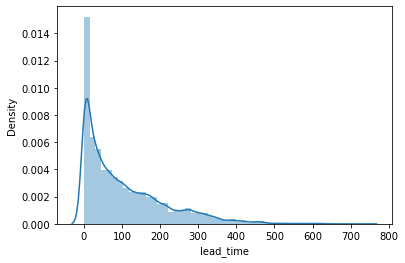

In [39]:
sns.distplot(dataframe["lead_time"])

<AxesSubplot:xlabel='lead_time'>

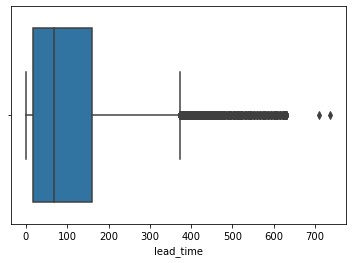

In [40]:
sns.boxplot(x = 'lead_time', data = dataframe, orient = 'h')

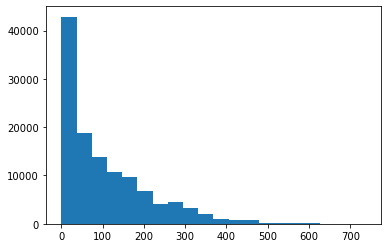

In [41]:
#realizar para canceled
plt.hist(dataframe["lead_time"], bins=20)
plt.show()

## Distribuição de Reservas

- Hotel
- Resort

In [42]:
frequence_hotel = dataframe['hotel'].value_counts()
percentage_hotel = dataframe['hotel'].value_counts(normalize = True) * 100
distribution_frequence_hotel = pd.DataFrame({'Frequence': frequence_hotel, 'Percentage (%)': percentage_hotel})
distribution_frequence_hotel.rename_axis('Hotel Type', axis= 'columns', inplace = True)

distribution_frequence_hotel

Hotel Type,Frequence,Percentage (%)
City Hotel,79330,66.446101
Resort Hotel,40060,33.553899


### Graphs - hotel

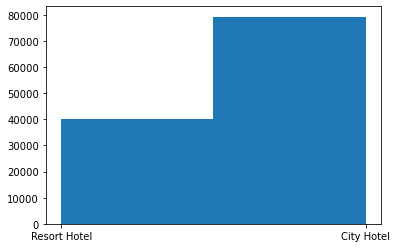

In [43]:
plt.hist(dataframe["hotel"], bins=2)
plt.show()

## Adults

- A média de adultos por reserva

In [44]:
distribution_frequences_adults = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'adults', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'adults', class_number)}
)

distribution_frequences_adults.rename_axis('Adults', axis= 'columns', inplace = True)
print_media_median_mode(dataframe, "adults")
statistics_test_adults, p_value_adults = normaltest(dataframe["adults"])
print('Not a normal distribution' if p_value_adults <= significance else 'It"s normal distribution')
distribution_frequences_adults

Mean is 1.8564033838679956 
Median is 2.0
Mode is 2
Not a normal distribution


Adults,Frequence,Porcentage (%)
"(-0.056, 3.056]",119312,0.999347
"(3.056, 6.111]",65,0.000544
"(6.111, 9.167]",0,0.000000
"(9.167, 12.222]",1,0.000008
"(12.222, 15.278]",0,0.000000
"(15.278, 18.333]",0,0.000000
"(18.333, 21.389]",2,0.000017
"(21.389, 24.444]",0,0.000000
"(24.444, 27.5]",7,0.000059
"(27.5, 30.556]",0,0.000000


### Graphs - adults

<AxesSubplot:xlabel='adults', ylabel='Density'>

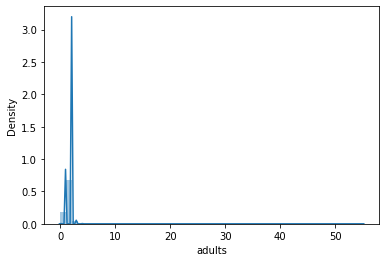

In [45]:
sns.distplot(dataframe["adults"])

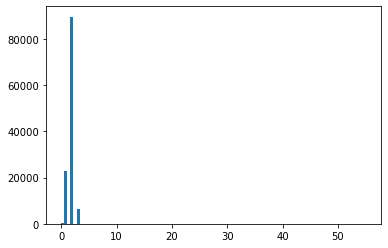

In [46]:
plt.hist(dataframe["adults"], bins=100)
plt.show()

## Children

- A média de crianças por reserva

In [47]:
distribution_frequences_children = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'children', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'children', class_number)}
)
distribution_frequences_children.rename_axis('Children', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "children")
statistics_test_children, p_value_children = normaltest(dataframe["children"])
print('Not a normal distribution' if p_value_children <= significance else 'It"s normal distribution')
distribution_frequences_children

Mean is 0.10388990333874994 
Median is 0.0
Mode is 0.0
It"s normal distribution


Children,Frequence,Porcentage (%)
"(-0.011, 0.556]",110796,0.928049
"(0.556, 1.111]",4861,0.040717
"(1.111, 1.667]",0,0.000000
"(1.667, 2.222]",3652,0.030590
"(2.222, 2.778]",0,0.000000
"(2.778, 3.333]",76,0.000637
"(3.333, 3.889]",0,0.000000
"(3.889, 4.444]",0,0.000000
"(4.444, 5.0]",0,0.000000
"(5.0, 5.556]",0,0.000000


### Graphs - children

<AxesSubplot:xlabel='children', ylabel='Density'>

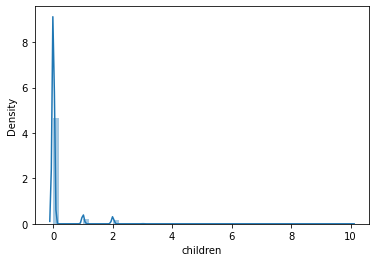

In [48]:
sns.distplot(dataframe['children'])

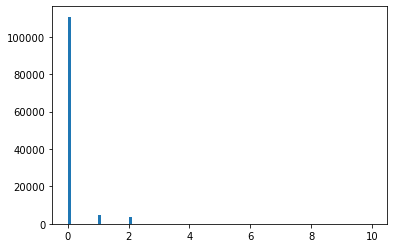

In [49]:
plt.hist(dataframe["children"], bins=100)
plt.show()

## babies

- A Média de bebés por reserva

In [50]:
distribution_frequences_babies = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'babies', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'babies', class_number)}
)
distribution_frequences_babies.rename_axis('Babies', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "babies")

statistics_test_babies, p_value_babies = normaltest(dataframe["babies"])
print('Not a normal distribution' if p_value_babies <= significance else 'It"s normal distribution')
distribution_frequences_babies

Mean is 0.007948739425412514 
Median is 0.0
Mode is 0
Not a normal distribution


Babies,Frequence,Porcentage (%)
"(-0.011, 0.556]",118473,0.992319
"(0.556, 1.111]",900,0.007538
"(1.111, 1.667]",0,0.000000
"(1.667, 2.222]",15,0.000126
"(2.222, 2.778]",0,0.000000
"(2.778, 3.333]",0,0.000000
"(3.333, 3.889]",0,0.000000
"(3.889, 4.444]",0,0.000000
"(4.444, 5.0]",0,0.000000
"(5.0, 5.556]",0,0.000000


### Graphs - babies

<AxesSubplot:xlabel='babies', ylabel='Density'>

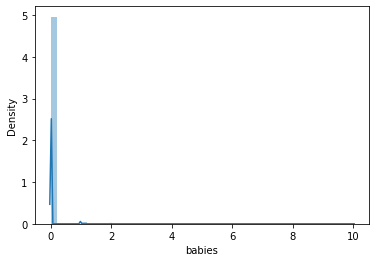

In [51]:
sns.distplot(dataframe["babies"])

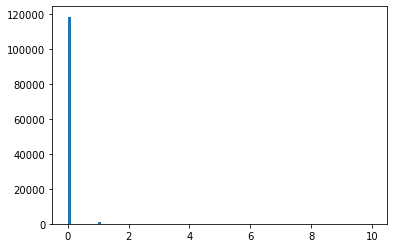

In [52]:
plt.hist(dataframe["babies"], bins=100)
plt.show()

## arrival_date_week_number

- Número de chegadas por semana

In [53]:
distribution_frequences_arrival_date_week_number = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'arrival_date_week_number', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'arrival_date_week_number', class_number)}
)
distribution_frequences_arrival_date_week_number.rename_axis('Arrival Date Week', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "arrival_date_week_number")

statistics_test_arrival_date_week_number, p_value_arrival_date_week_number = normaltest(dataframe["arrival_date_week_number"])
print('Not a normal distribution' if p_value_arrival_date_week_number <= significance else 'It"s normal distribution')
distribution_frequences_arrival_date_week_number

Mean is 27.16517296255968 
Median is 28.0
Mode is 33
Not a normal distribution


Arrival Date Week,Frequence,Porcentage (%)
"(0.947, 3.889]",3584,0.030019
"(3.889, 6.778]",4382,0.036703
"(6.778, 9.667]",6442,0.053958
"(9.667, 12.556]",6302,0.052785
"(12.556, 15.444]",7369,0.061722
"(15.444, 18.333]",8136,0.068146
"(18.333, 21.222]",8041,0.067351
"(21.222, 24.111]",7665,0.064201
"(24.111, 27.0]",7718,0.064645
"(27.0, 29.889]",5616,0.047039


### Graphs - arrival_date_week_number

<AxesSubplot:xlabel='arrival_date_week_number', ylabel='Density'>

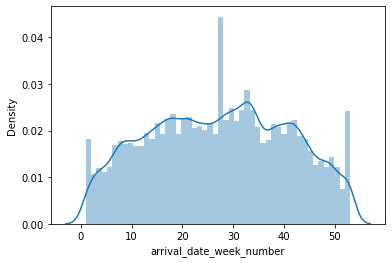

In [54]:
sns.distplot(dataframe["arrival_date_week_number"])

<AxesSubplot:xlabel='arrival_date_week_number'>

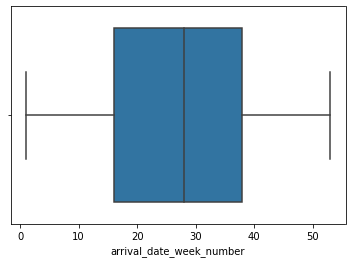

In [55]:
sns.boxplot( x = 'arrival_date_week_number', data = dataframe, orient = 'h')

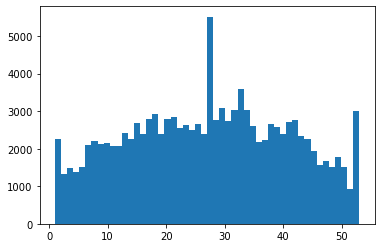

In [56]:
plt.hist(dataframe["arrival_date_week_number"], bins=50)
plt.show()

## stays_in_week_nights

- Número de noites na semana (seg - sex)

In [57]:
distribution_frequences_stays_in_week_nights = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'stays_in_week_nights', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'stays_in_week_nights', class_number)}
)
distribution_frequences_stays_in_week_nights.rename_axis('Stays in Week Nights', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "stays_in_week_nights")

statistics_test_arrival_stays_in_week_nights, p_value_stays_in_week_nights = normaltest(dataframe["stays_in_week_nights"])
print('Not a normal distribution' if p_value_stays_in_week_nights <= significance else 'It"s normal distribution')
distribution_frequences_stays_in_week_nights

Mean is 2.500301532791691 
Median is 2.0
Mode is 2
Not a normal distribution


Stays in Week Nights,Frequence,Porcentage (%)
"(-0.051000000000000004, 2.778]",71639,0.600042
"(2.778, 5.556]",42898,0.359310
"(5.556, 8.333]",3184,0.026669
"(8.333, 11.111]",1323,0.011081
"(11.111, 13.889]",69,0.000578
"(13.889, 16.667]",136,0.001139
"(16.667, 19.444]",54,0.000452
"(19.444, 22.222]",63,0.000528
"(22.222, 25.0]",9,0.000075
"(25.0, 27.778]",1,0.000008


### Graphs - stays_in_week_nights

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

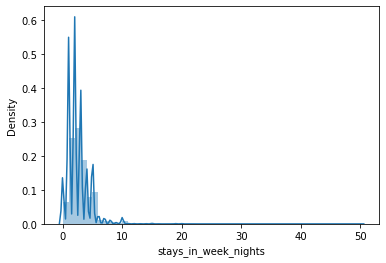

In [58]:
sns.distplot(dataframe["stays_in_week_nights"])

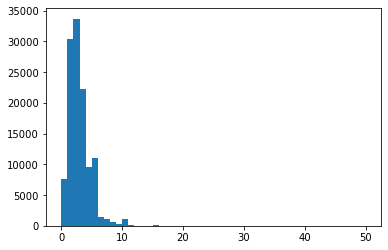

In [59]:
plt.hist(dataframe["stays_in_week_nights"], bins=50)
plt.show()

## reservation_status_date

### Graphs - reservation_status_date

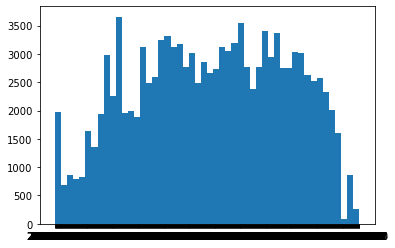

In [60]:
plt.hist(dataframe["reservation_status_date"], bins=50)
plt.show()

## Jaccard Analysis

- Cálculos do jaccard e densidade da amostra.
- Diminuimos a amostra porque a dimensão sobrecarrega o sistema.
- Executamos com amostra de 5000*15

### Determinar se a variável hotel influencia no cancelamento ou não.


In [61]:
#Utilizando a função da seguinte forma.

- Transformação das tipologias em classificão:  city hotel(0),  resort (1)

In [62]:
dataframe['hotel_binary'] = np.where(dataframe['hotel'] == 'City Hotel', 0, 1)
sample_two_variables = dataframe[["is_canceled", "hotel_binary"]].sample(n = 5000).values
jaccard_similarity = jaccard_generalized(sample_two_variables)
for _ in range(14):
    sample_two_variables = dataframe[["is_canceled", "hotel_binary"]].sample(n = 5000).values
    jaccard_similarity = jaccard_similarity + jaccard_generalized(sample_two_variables)
jaccard_similarity = jaccard_similarity / 15

-  A medida de jaccard é utilizada para medir a similaridade da diversidade de conjuntos.

In [63]:
jaccard_similarity

array([[0.73333333, 0.3       , 0.1       , ..., 0.2       , 0.3       ,
        0.16666667],
       [0.3       , 0.8       , 0.13333333, ..., 0.33333333, 0.33333333,
        0.3       ],
       [0.1       , 0.13333333, 0.26666667, ..., 0.16666667, 0.1       ,
        0.06666667],
       ...,
       [0.2       , 0.33333333, 0.16666667, ..., 0.6       , 0.23333333,
        0.23333333],
       [0.3       , 0.33333333, 0.1       , ..., 0.23333333, 0.73333333,
        0.4       ],
       [0.16666667, 0.3       , 0.06666667, ..., 0.23333333, 0.4       ,
        0.6       ]])

- A densidade da similaridade, que são  quantos valores de estão acima de 0, o que significa o quão forte são as arestas ou ligações temos entre nós (cancelamentos).

In [64]:
density_jaccard_similarity = np.sum(jaccard_similarity > 0)
density_jaccard_similarity

24623402

- Número total de entradas possiveis (Degree)

In [65]:
size_sample_two_variables = sample_two_variables.shape[0]*sample_two_variables.shape[0]
size_sample_two_variables

25000000

- Foi utilizado o Generalized Jaccard Index.(uma divisão)

- A divisão da densidade da similaridade e quais variáveis em causa (Hotéis e cancelamentos)

In [66]:
density_jaccard_similarity/size_sample_two_variables

0.98493608

- Para projetar os nossos dados que representam os cancelamentos das reservas dos hotéis em um gráfico e assim verificar a medida de similaridade através Jaccard generalizado. 

 - medida esta que mede a co-probabilidade de cancelamentos para hotéis.

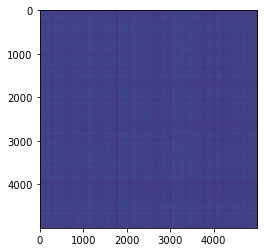

In [67]:
plt.imshow(jaccard_similarity)

In [68]:
co_probability = jaccard_similarity[jaccard_similarity > 0.0]

In [69]:
#probabilidade dos cancelamentos por tipologia de hotel

In [70]:
co_probability

array([0.73333333, 0.3       , 0.1       , ..., 0.23333333, 0.4       ,
       0.6       ])

- A comparação de todas as co-probabilidades entre os cancelamentos dos hoteis. 

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 7.341280e+05,
        0.000000e+00, 0.000000e+00, 1.741974e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.348110e+06, 0.000000e+00,
        0.000000e+00, 3.260021e+06, 0.000000e+00, 0.000000e+00,
        3.385100e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.472274e+06, 0.000000e+00, 0.000000e+00, 2.930272e+06,
        0.000000e+00, 0.000000e+00, 2.403192e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.697832e+06, 0.000000e+00,
        0.000000e+00, 1.155721e+06, 0.000000e+00, 0.000000e+00,
        6.954100e+05, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.042440e+05, 0.000000e+00, 0.000000e+00, 2.085820e+05,
        0.000000e+00, 0.000000e+00, 1.043920e+05, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 4.614400e+04, 0.000000e+00,
        0.000000e+00, 2.065100e+04, 0.000000e+00, 0.000000e+00,
        7.968000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.729000e+03, 0.000000e+00, 0.00

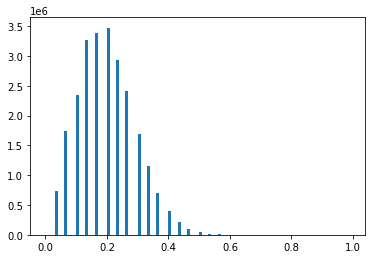

In [71]:
plt.hist(co_probability, bins=np.arange(0,1,0.01))

- A densidade da co-probabilidade maior que 0.7. Ou seja, quantos valores de co-probabilidade estão acima de 0.7, o que significa a força dos relacionamentos entre as arestas ou ligações temos entre nós (cancelamentos).


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 742.,   0.,   0.,   6.,
          0.,   0.,   0., 376.,   0.,   0.,   2.,   0.,   0., 150.,   0.,
          0.,   0.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,   0.,   0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48

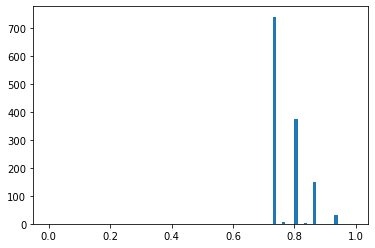

In [72]:
plt.hist(co_probability[co_probability > 0.7],bins=np.arange(0,1,0.01))

- A densidade da cooprobabilidade menor que 0.7. Ou seja, quantos valores de cooprobabilidade estão abaixo de 0.7, o que significa na teoria dos grafos quantas arestas ou ligações temos entre nós (cancelamentos).

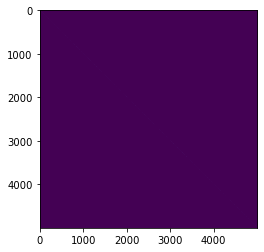

In [73]:
jaccard_similarity_version_2 = jaccard_similarity.copy()
jaccard_similarity_version_2[jaccard_similarity < 0.7] = 0.0
plt.imshow(jaccard_similarity_version_2)

In [74]:
np.sum(jaccard_similarity_version_2 > 0)/(sample_two_variables.shape[0]*sample_two_variables.shape[0])

5.592e-05

## Metric Backbone

- Permite-nos reduzir a redundância da amostra.

In [75]:
jaccard_similarity_to_metric_backbone = jaccard_similarity.copy()

In [76]:
distance_prox_2 = prox2dist(jaccard_similarity_to_metric_backbone, 1)

In [77]:
distance_all_pairs = all_pairs_sp(distance_prox_2)

In [78]:
s_value = s_ratio(distance_prox_2, distance_all_pairs)

In [79]:
semimetric_percentage_value = Semimetric_Percentage(s_value)
print(semimetric_percentage_value)

0.8924259178154618


In [80]:
metric_backbone_value = Metric_backbone(jaccard_similarity_to_metric_backbone)

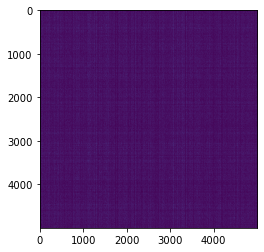

In [81]:
plt.imshow(metric_backbone_value)

In [82]:
d_metric_backbone_value = metric_backbone_value[metric_backbone_value > 0]

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 6.50000e+02, 0.00000e+00,
        0.00000e+00, 1.69800e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.39000e+04, 0.00000e+00, 0.00000e+00, 5.05480e+04, 0.00000e+00,
        0.00000e+00, 2.10478e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        4.03738e+05, 0.00000e+00, 0.00000e+00, 6.77012e+05, 0.00000e+00,
        0.00000e+00, 5.36532e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.72014e+05, 0.00000e+00, 0.00000e+00, 2.01154e+05, 0.00000e+00,
        0.00000e+00, 1.02820e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        4.59140e+04, 0.00000e+00, 0.00000e+00, 1.98380e+04, 0.00000e+00,
        0.00000e+00, 7.96400e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.69400e+03, 0.00000e+00, 0.00000e+00, 9.66000e+02, 0.00000e+00,
        0.00000e+00, 2.58000e+02, 0.00000e+00, 0.00

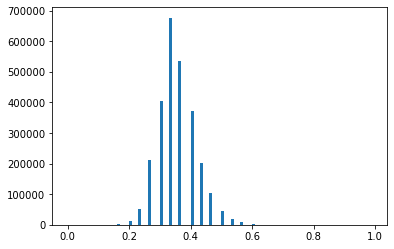

In [83]:
plt.hist(d_metric_backbone_value, bins = np.arange(0, 1, 0.01))

In [84]:
graph_jaccard_similarity = nx.from_numpy_array(metric_backbone_value)
nx.write_pajek(graph_jaccard_similarity, 'sample_01.net')

### Determinar se a variável is_repeated_guest influencia no cancelamento ou não.

In [85]:
sample_variables_is_repeated_guest = dataframe[["is_canceled", "is_repeated_guest"]].sample(n = 5000).values
jaccard_similarity_is_repeated_guest = jaccard_generalized(sample_variables_is_repeated_guest)
for _ in range(14):
    sample_variables_is_repeated_guest = dataframe[["is_canceled", "is_repeated_guest"]].sample(n = 5000).values
    jaccard_similarity_is_repeated_guest = jaccard_similarity_is_repeated_guest + jaccard_generalized(sample_variables_is_repeated_guest)
jaccard_similarity_is_repeated_guest = jaccard_similarity_is_repeated_guest / 15

In [86]:
jaccard_similarity_is_repeated_guest

array([[0.53333333, 0.26666667, 0.13333333, ..., 0.2       , 0.2       ,
        0.33333333],
       [0.26666667, 0.53333333, 0.13333333, ..., 0.06666667, 0.2       ,
        0.26666667],
       [0.13333333, 0.13333333, 0.26666667, ..., 0.13333333, 0.06666667,
        0.13333333],
       ...,
       [0.2       , 0.06666667, 0.13333333, ..., 0.46666667, 0.06666667,
        0.26666667],
       [0.2       , 0.2       , 0.06666667, ..., 0.06666667, 0.26666667,
        0.2       ],
       [0.33333333, 0.26666667, 0.13333333, ..., 0.26666667, 0.2       ,
        0.66666667]])

In [87]:
density_jaccard_similarity_is_repeated_guest = np.sum(jaccard_similarity_is_repeated_guest > 0)
density_jaccard_similarity_is_repeated_guest

22333170

In [88]:
size_sample_two_variables_is_repeated_guest = sample_variables_is_repeated_guest.shape[0]*sample_variables_is_repeated_guest.shape[0]
size_sample_two_variables_is_repeated_guest

25000000

In [91]:
density_jaccard_similarity_is_repeated_guest/size_sample_two_variables_is_repeated_guest

0.8933268

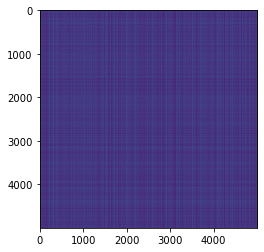

In [93]:
plt.imshow(jaccard_similarity_is_repeated_guest)

In [94]:
co_probability_is_repeated_guest = jaccard_similarity_is_repeated_guest[jaccard_similarity_is_repeated_guest > 0.0]

In [95]:
co_probability_is_repeated_guest

array([0.53333333, 0.26666667, 0.13333333, ..., 0.26666667, 0.2       ,
       0.66666667])

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 1.739480e+05,
        0.000000e+00, 0.000000e+00, 6.220201e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 3.803480e+05, 0.000000e+00,
        0.000000e+00, 6.828293e+06, 0.000000e+00, 0.000000e+00,
        3.932820e+05, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.663061e+06, 0.000000e+00, 0.000000e+00, 2.524460e+05,
        0.000000e+00, 0.000000e+00, 2.216331e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.130880e+05, 0.000000e+00,
        0.000000e+00, 7.771690e+05, 0.000000e+00, 0.000000e+00,
        3.781000e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.098740e+05, 0.000000e+00, 0.000000e+00, 9.454000e+03,
        0.000000e+00, 0.000000e+00, 4.554300e+04, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.892000e+03, 0.000000e+00,
        0.000000e+00, 8.308000e+03, 0.000000e+00, 0.000000e+00,
        2.740000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.451000e+03, 0.000000e+00, 0.00

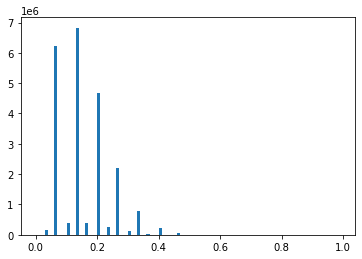

In [96]:
plt.hist(co_probability_is_repeated_guest, bins=np.arange(0,1,0.01))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 57.,  0.,  0.,  0.,  0.,
         0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0

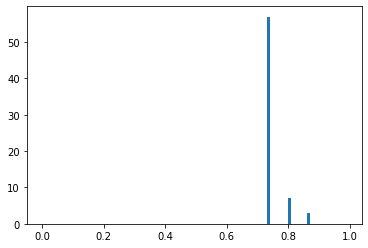

In [97]:
plt.hist(co_probability_is_repeated_guest[co_probability_is_repeated_guest > 0.7], bins=np.arange(0,1,0.01))

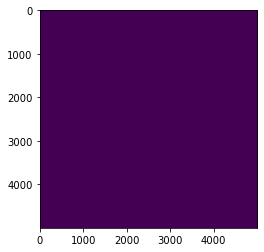

In [98]:
jaccard_similarity_is_repeated_guest_version_2 = jaccard_similarity_is_repeated_guest.copy()
jaccard_similarity_is_repeated_guest_version_2[jaccard_similarity_is_repeated_guest < 0.7] = 0.0
plt.imshow(jaccard_similarity_is_repeated_guest_version_2)

In [99]:
np.sum(jaccard_similarity_is_repeated_guest_version_2 > 0)/(sample_variables_is_repeated_guest.shape[0]*sample_variables_is_repeated_guest.shape[0])

2.76e-06

0.86954337327749


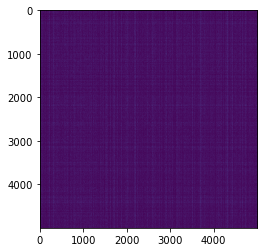

In [100]:
jaccard_similarity_is_repeated_guest_to_metric_backbone = jaccard_similarity_is_repeated_guest.copy()
distance_prox_is_repeated_guest_2 = prox2dist(jaccard_similarity_is_repeated_guest_to_metric_backbone, 1)
distance_all_pairs_is_repeated_guest = all_pairs_sp(distance_prox_is_repeated_guest_2)
s_value_is_repeated_guest = s_ratio(distance_prox_is_repeated_guest_2, distance_all_pairs_is_repeated_guest)
semimetric_percentage_value_is_repeated_guest = Semimetric_Percentage(s_value_is_repeated_guest)
print(semimetric_percentage_value_is_repeated_guest)
metric_backbone_value_is_repeated_guest = Metric_backbone(jaccard_similarity_is_repeated_guest_to_metric_backbone)
plt.imshow(metric_backbone_value_is_repeated_guest)

In [104]:
d_metric_backbone_value_is_repeated_guest = metric_backbone_value_is_repeated_guest[metric_backbone_value_is_repeated_guest > 0]

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 7.41740e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.31000e+03, 0.00000e+00, 0.00000e+00, 2.24328e+05, 0.00000e+00,
        0.00000e+00, 2.34880e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        7.04516e+05, 0.00000e+00, 0.00000e+00, 5.12640e+04, 0.00000e+00,
        0.00000e+00, 8.41740e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        6.12820e+04, 0.00000e+00, 0.00000e+00, 6.38778e+05, 0.00000e+00,
        0.00000e+00, 2.95880e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.97870e+05, 0.00000e+00, 0.00000e+00, 8.87000e+03, 0.00000e+00,
        0.00000e+00, 4.44200e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.89000e+03, 0.00000e+00, 0.00000e+00, 7.71400e+03, 0.00000e+00,
        0.00000e+00, 2.74000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.13000e+03, 0.00000e+00, 0.00000e+00, 2.80000e+01, 0.00000e+00,
        0.00000e+00, 1.78000e+02, 0.00000e+00, 0.00

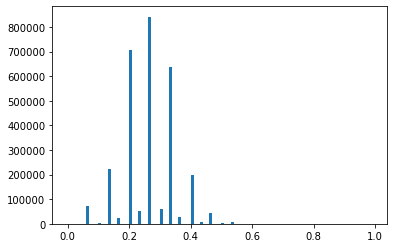

In [105]:
plt.hist(d_metric_backbone_value_is_repeated_guest, bins = np.arange(0, 1, 0.01))

In [106]:
graph_jaccard_similarity_is_repeated_guest = nx.from_numpy_array(metric_backbone_value_is_repeated_guest)
nx.write_pajek(graph_jaccard_similarity_is_repeated_guest, 'is_repeated_guest_01.net')

### Jaccard between columns

In [166]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
only_numeric_variables = dataframe.select_dtypes(include=numerics)
only_numeric_variables = only_numeric_variables.replace(np.nan,0)
only_numeric_variables.T

,0,1,2,3,4,5,6,7,8,9,...,119380,119381,119382,119383,119384,119385,119386,119387,119388,119389
is_canceled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
lead_time,342.0,737.0,7.0,13.0,14.0,14.0,0.0,9.0,85.0,75.0,...,44.00,188.0,135.0,164.0,21.00,23.00,102.00,34.00,109.0,205.0
arrival_date_year,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,...,2017.00,2017.0,2017.0,2017.0,2017.00,2017.00,2017.00,2017.00,2017.0,2017.0
arrival_date_week_number,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,35.00,35.0,35.0,35.0,35.00,35.00,35.00,35.00,35.0,35.0
arrival_date_day_of_month,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,31.00,31.0,30.0,31.0,30.00,30.00,31.00,31.00,31.0,29.0
stays_in_weekend_nights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,2.0,2.0,2.0,2.00,2.00,2.00,2.00,2.0,2.0
stays_in_week_nights,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.00,3.0,4.0,4.0,5.00,5.00,5.00,5.00,5.0,7.0
adults,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.00,2.0,3.0,2.0,2.00,2.00,3.00,2.00,2.0,2.0
children,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
babies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0


In [168]:
sample_only_numeric_variables = only_numeric_variables.T.values
jaccard_similarity_only_numeric_variables = jaccard_generalized(sample_only_numeric_variables)
jaccard_similarity_only_numeric_variables

array([[1.00000000e+00, 3.52655461e-03, 1.83723968e-04, 1.36357049e-02,
        2.34466787e-02, 1.89816272e-01, 1.40837616e-01, 1.98944734e-01,
        5.84288144e-02, 3.71061636e-03, 1.16254581e-02, 1.22054927e-01,
        3.31169691e-03, 4.17902081e-02, 4.49708837e-03, 8.95839648e-04,
        7.39528570e-03, 3.61940354e-03, 0.00000000e+00, 1.04823574e-01],
       [3.52655461e-03, 1.00000000e+00, 5.15889583e-02, 1.93406170e-01,
        1.21847057e-01, 8.67618079e-03, 2.31531593e-02, 1.68202744e-02,
        9.54626379e-04, 7.24756023e-05, 2.14347756e-04, 7.96799660e-04,
        6.07077621e-04, 1.97628331e-03, 2.22867698e-01, 2.13705449e-02,
        2.23162923e-02, 3.87678877e-01, 5.34594953e-04, 5.26716817e-03],
       [1.83723968e-04, 5.15889583e-02, 1.00000000e+00, 1.34737419e-02,
        7.83582060e-03, 4.60082638e-04, 1.24013263e-03, 9.20763509e-04,
        5.15269622e-05, 3.94252094e-06, 1.58282453e-05, 4.32098633e-05,
        6.79991388e-05, 1.09676030e-04, 3.71143396e-02, 5.3444

In [169]:
density_jaccard_similarity_only_numeric_variables = np.sum(jaccard_similarity_only_numeric_variables > 0)
density_jaccard_similarity_only_numeric_variables

398

In [170]:
size_sample_two_variables_only_numeric_variables = sample_only_numeric_variables.shape[0]*sample_only_numeric_variables.shape[0]
size_sample_two_variables_only_numeric_variables

400

In [171]:
density_jaccard_similarity_only_numeric_variables/size_sample_two_variables_only_numeric_variables

0.995

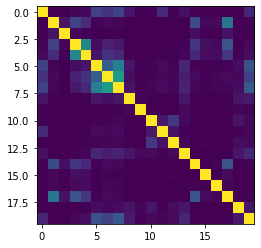

In [172]:
plt.imshow(jaccard_similarity_only_numeric_variables)

In [173]:
co_probability_only_numeric_variables = jaccard_similarity_only_numeric_variables[jaccard_similarity_only_numeric_variables > 0.0]

In [174]:
co_probability_only_numeric_variables

array([1.00000000e+00, 3.52655461e-03, 1.83723968e-04, 1.36357049e-02,
       2.34466787e-02, 1.89816272e-01, 1.40837616e-01, 1.98944734e-01,
       5.84288144e-02, 3.71061636e-03, 1.16254581e-02, 1.22054927e-01,
       3.31169691e-03, 4.17902081e-02, 4.49708837e-03, 8.95839648e-04,
       7.39528570e-03, 3.61940354e-03, 1.04823574e-01, 3.52655461e-03,
       1.00000000e+00, 5.15889583e-02, 1.93406170e-01, 1.21847057e-01,
       8.67618079e-03, 2.31531593e-02, 1.68202744e-02, 9.54626379e-04,
       7.24756023e-05, 2.14347756e-04, 7.96799660e-04, 6.07077621e-04,
       1.97628331e-03, 2.22867698e-01, 2.13705449e-02, 2.23162923e-02,
       3.87678877e-01, 5.34594953e-04, 5.26716817e-03, 1.83723968e-04,
       5.15889583e-02, 1.00000000e+00, 1.34737419e-02, 7.83582060e-03,
       4.60082638e-04, 1.24013263e-03, 9.20763509e-04, 5.15269622e-05,
       3.94252094e-06, 1.58282453e-05, 4.32098633e-05, 6.79991388e-05,
       1.09676030e-04, 3.71143396e-02, 5.34440494e-03, 1.15127427e-03,
      

(array([190.,  40.,  38.,  20.,   2.,  20.,   8.,   4.,   0.,   4.,   6.,
          4.,   4.,   0.,   4.,   4.,   2.,   0.,   2.,   6.,   0.,   0.,
          2.,   0.,   2.,   2.,   2.,   2.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48

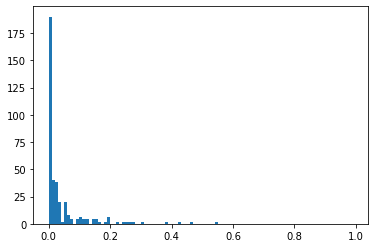

In [175]:
plt.hist(co_probability_only_numeric_variables, bins=np.arange(0,1,0.01))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81

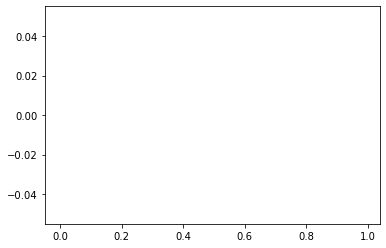

In [176]:
plt.hist(co_probability_only_numeric_variables[co_probability_only_numeric_variables > 0.7], bins=np.arange(0,1,0.01))

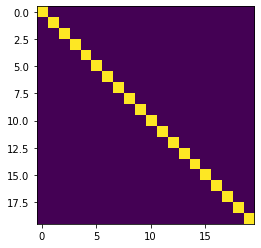

In [177]:
jaccard_similarity_only_numeric_variables_2 = jaccard_similarity_only_numeric_variables.copy()
jaccard_similarity_only_numeric_variables_2[jaccard_similarity_only_numeric_variables < 0.7] = 0.0
plt.imshow(jaccard_similarity_only_numeric_variables_2)

In [178]:
np.sum(jaccard_similarity_only_numeric_variables_2 > 0)/(sample_only_numeric_variables.shape[0]*sample_only_numeric_variables.shape[0])

0.05

0.8201058201058201


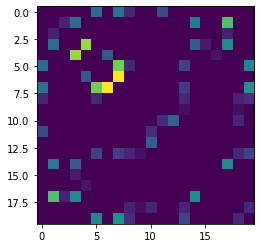

In [179]:
jaccard_similarity_only_numeric_variables_to_metric_backbone = jaccard_similarity_only_numeric_variables.copy()
distance_prox_only_numeric_variables_2 = prox2dist(jaccard_similarity_only_numeric_variables_to_metric_backbone, 1)
distance_all_pairs_only_numeric_variables = all_pairs_sp(distance_prox_only_numeric_variables_2)
s_value_only_numeric_variables = s_ratio(distance_prox_only_numeric_variables_2, distance_all_pairs_only_numeric_variables)
semimetric_percentage_value_only_numeric_variables = Semimetric_Percentage(s_value_only_numeric_variables)
print(semimetric_percentage_value_only_numeric_variables)
metric_backbone_value_only_numeric_variables = Metric_backbone(jaccard_similarity_only_numeric_variables_to_metric_backbone)
plt.imshow(metric_backbone_value_only_numeric_variables)

In [180]:
d_metric_backbone_value_only_numeric_variables = metric_backbone_value_only_numeric_variables[metric_backbone_value_only_numeric_variables > 0]

(array([ 0.,  2.,  4.,  2.,  0., 14.,  6.,  2.,  0.,  2.,  4.,  0.,  2.,
         0.,  2.,  2.,  2.,  0.,  2.,  4.,  0.,  0.,  2.,  0.,  2.,  2.,
         2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0

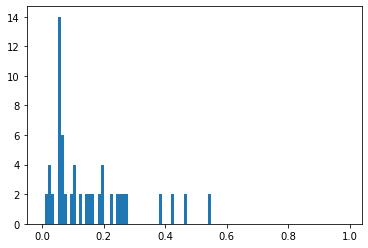

In [181]:
plt.hist(d_metric_backbone_value_only_numeric_variables, bins = np.arange(0, 1, 0.01))

In [191]:
graph_jaccard_similarity_only_numeric_variables = nx.from_numpy_array(metric_backbone_value_only_numeric_variables)
nx.write_pajek(graph_jaccard_similarity_only_numeric_variables, 'only_numeric_variables_01.net')

### Pearson Correlation (postive values) and heatmap

<AxesSubplot:>

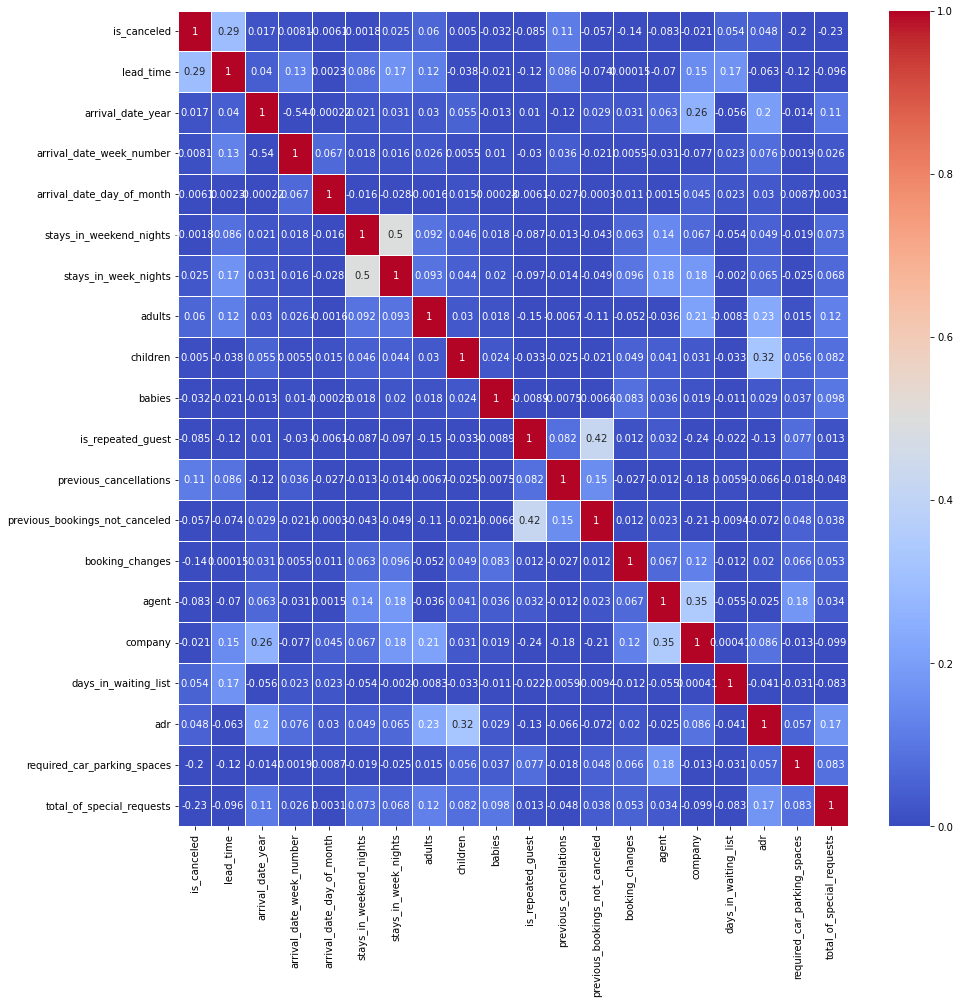

In [138]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dataframe.corr(), annot = True, vmin=0, vmax=1, cmap='coolwarm', linewidths=.5, ax=ax)

### Pearson Correlation (negative values) and heatmap

<AxesSubplot:>

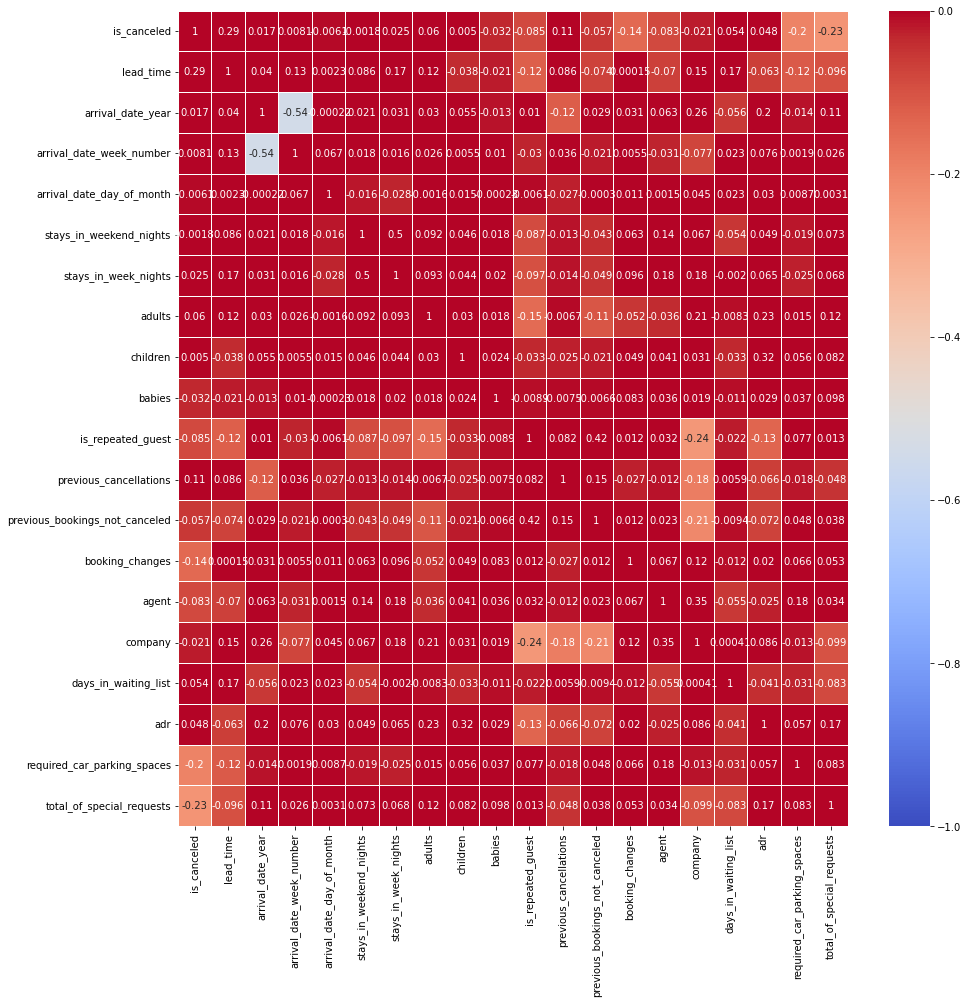

In [183]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dataframe.corr(), annot = True, vmin=-1, vmax=0, cmap='coolwarm', linewidths=.5, ax=ax)